In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/car_data.csv'  # change this path
df = pd.read_csv(file_path)

df.head()


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Driven_kms,0
Fuel_Type,0
Selling_type,0
Transmission,0
Owner,0


In [5]:
y = df['Selling_Price']
X = df.drop(columns=['Selling_Price'])

In [6]:
X = X.drop(columns=['id'], errors='ignore')

In [7]:
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['Year', 'Present_Price', 'Driven_kms', 'Owner']
Categorical Columns: ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']


In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pipelines = {
    'LinearRegression': Pipeline([('preproc', preprocessor),
                                  ('model', LinearRegression())]),

    'DecisionTree': Pipeline([('preproc', preprocessor),
                              ('model', DecisionTreeRegressor(random_state=42))]),

    'RandomForest': Pipeline([('preproc', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=200, random_state=42))]),

    'GradientBoosting': Pipeline([('preproc', preprocessor),
                                  ('model', GradientBoostingRegressor(random_state=42))])
}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f"{name} trained successfully!")


LinearRegression trained successfully!
DecisionTree trained successfully!
RandomForest trained successfully!
GradientBoosting trained successfully!


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mae, rmse, r2, y_pred


In [13]:
results = {}

for name, pipe in pipelines.items():
    mae, rmse, r2, y_pred = evaluate_model(pipe, X_test, y_test)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Pred': y_pred}

    print(f"\n----- {name} -----")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2 Score: {r2:.4f}")



----- LinearRegression -----
MAE: 1.104
RMSE: 1.513
R2 Score: 0.9007

----- DecisionTree -----
MAE: 0.685
RMSE: 1.124
R2 Score: 0.9452

----- RandomForest -----
MAE: 0.599
RMSE: 0.906
R2 Score: 0.9644

----- GradientBoosting -----
MAE: 0.570
RMSE: 0.931
R2 Score: 0.9623


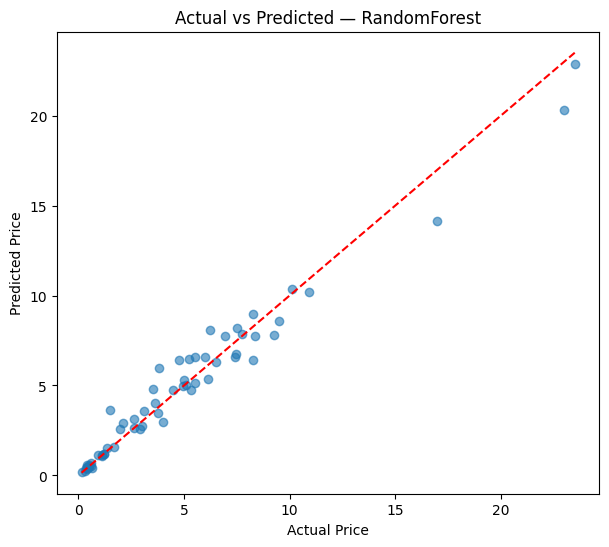

In [14]:
import matplotlib.pyplot as plt

best_model = 'RandomForest'
y_pred = results[best_model]['Pred']

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted — {best_model}")
plt.show()


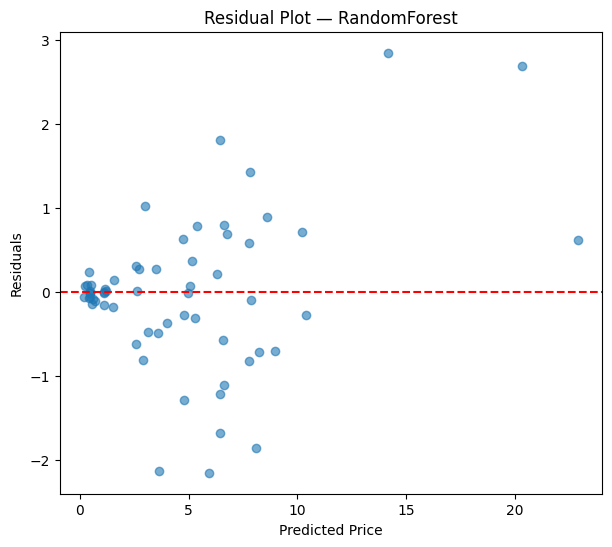

In [15]:
residuals = y_test - y_pred

plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title(f"Residual Plot — {best_model}")
plt.show()


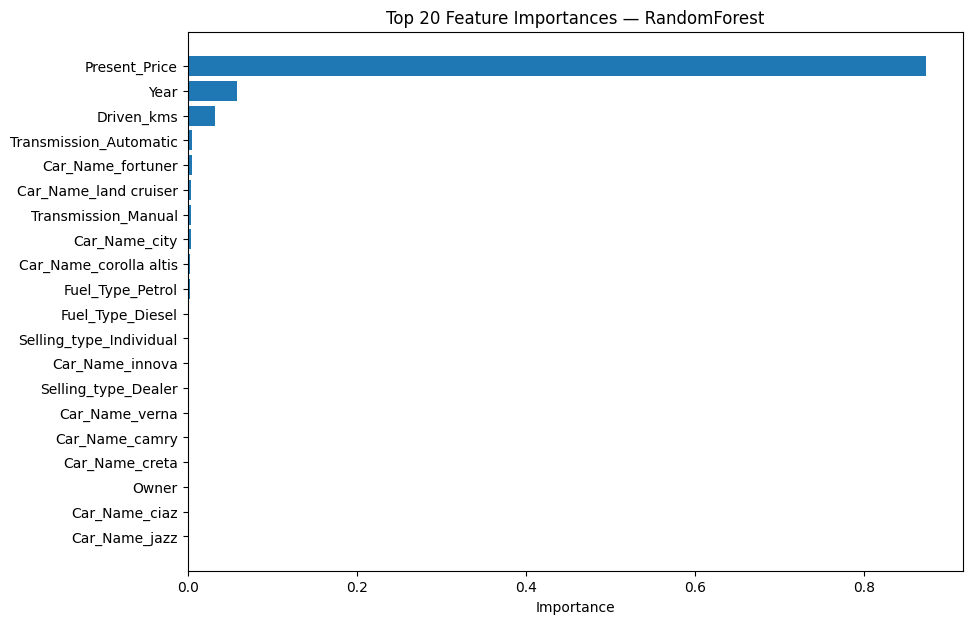

In [16]:
# Get feature names after encoding
ohe = pipelines[best_model].named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = numerical_cols + cat_names

model = pipelines[best_model].named_steps['model']
importances = model.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.barh(np.array(feature_names)[indices[:20]][::-1], importances[indices[:20]][::-1])
plt.title(f'Top 20 Feature Importances — {best_model}')
plt.xlabel('Importance')
plt.show()


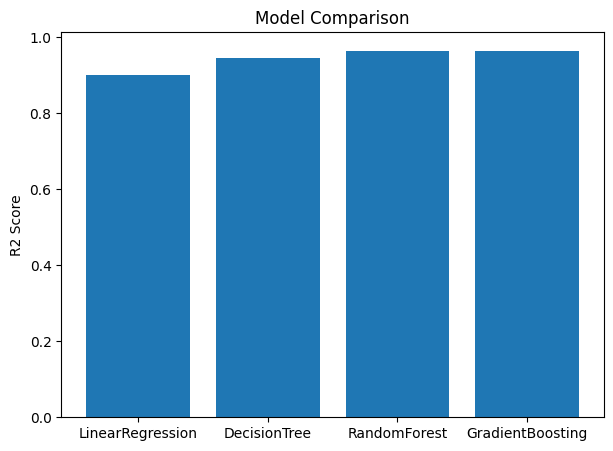

In [17]:
names = list(results.keys())
r2_scores = [results[m]['R2'] for m in names]

plt.figure(figsize=(7,5))
plt.bar(names, r2_scores)
plt.ylabel("R2 Score")
plt.title("Model Comparison")
plt.show()


In [19]:
import pickle

save_path = '/content/drive/MyDrive/best_car_price_model.pkl'  # change path if needed

with open(save_path, 'wb') as f:
    pickle.dump(pipelines[best_model], f)

print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/best_car_price_model.pkl
